In [39]:
import numpy as np
import matplotlib.pyplot as plt
from films_utils import *
from evaluation_utils import *
import pandas as pd
import random

## Work with dataframe (To change using local library)

In [40]:
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', 
                        names = ['UserID', 'MovieID', 'Rating', 'Timestamp'],
                        encoding = 'latin1',
                        engine = 'python')
movies  = pd.read_csv('ml-1m/movies.dat',  sep='::',
                        names = ['MovieID', 'Title', 'Genres'], 
                        encoding = 'latin1',
                        engine ='python')
users   = pd.read_csv('ml-1m/users.dat',  sep='::', 
                        names = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip'], 
                        encoding = 'latin1',
                        engine = 'python')

In [41]:
N = 1000
ratings_count = ratings.groupby(by='MovieID', as_index=True).size()
# top_ratings = ratings_count.sort_values(ascending=False)[:N]
top_ratings = ratings_count[ratings_count>=N]
top_ratings.head(10)

MovieID
1      2077
11     1033
21     1356
32     1511
34     1751
39     1362
47     1137
50     1783
110    2443
111    1240
dtype: int64

In [42]:
movies_topN = movies[movies.MovieID.isin(top_ratings.index)]
# print('Shape: {}'.format(movies_topN.shape))
# movies_topN
ratings_topN = ratings[ratings.MovieID.isin(top_ratings.index)]
print('Shape: {}'.format(ratings_topN.shape))
ratings_topN.head(10)

Shape: (305373, 4)


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
7,1,2804,5,978300719
9,1,919,4,978301368
10,1,595,5,978824268
13,1,2918,4,978302124
15,1,2791,4,978302188
19,1,2797,4,978302039


In [43]:
n_users = ratings_topN.UserID.unique().shape[0]
n_movies = ratings_topN.MovieID.unique().shape[0]
print('Number of users = {} | Number of movies = {}'.format(n_users, n_movies))

Number of users = 6039 | Number of movies = 207


In [44]:
R_df = ratings_topN.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
R = np.array(R_df)

# Méthode du coude pour déterminer l'intervalle de nb_clusters d'intérêt

Text(0.5, 1.0, 'Elbow curve')

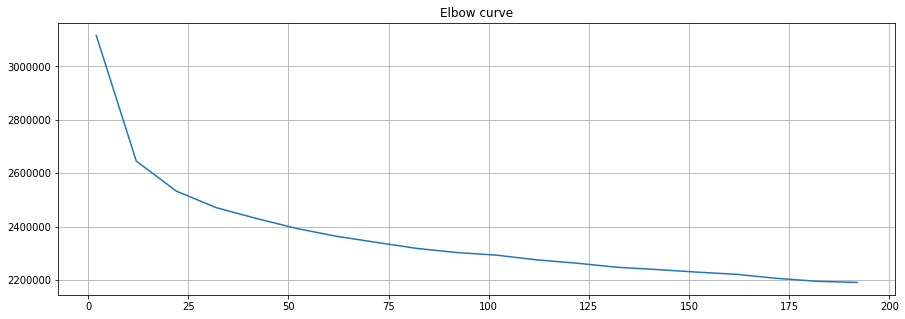

In [7]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

R = fill_matrix_MF(R, d = 30)

distorsions = []
for k in range(2, 200, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(R)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 200, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

# Fine tuning de nb_clusters

In [17]:
nb_rounds = 15
delta = 1/nb_rounds**2

gain_ucb, gain_random, gain_best_avg = [], [], []
d = 15
R_d = fill_matrix_MF(R, d = d)

for nb_clusters in range(2,80,4):

    labels = get_labels_from_clustering(nb_clusters, R_d)
    best_movies_by_cluster = get_best_movies_by_cluster(R, labels,nb_clusters)        
    gain_ucb.append(gain_NDGC(R_d, delta, best_movies_by_cluster, nb_clusters, nb_rounds, method = "UCB"))
    gain_random.append(gain_NDGC(R_d, delta, best_movies_by_cluster, nb_clusters, nb_rounds, method = "random"))
    gain_best_avg.append(gain_NDGC(R_d, delta, best_movies_by_cluster, nb_clusters, nb_rounds, method = "best_average"))
    

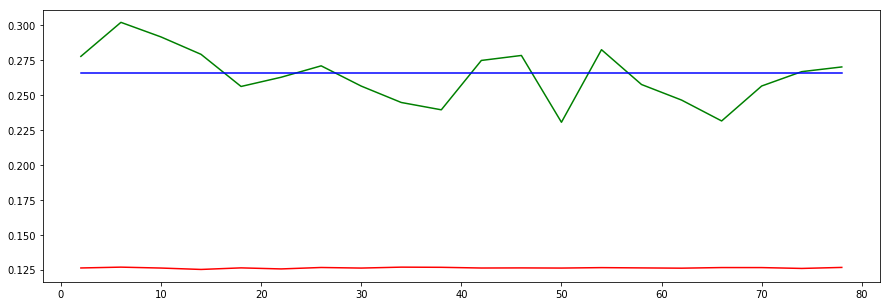

In [18]:
fig = plt.figure(figsize=(15, 5))

plt.plot(range(2,80,4), gain_ucb ,'g')
plt.plot(range(2,80,4), gain_random ,'r')
plt.plot(range(2,80,4), gain_best_avg ,'b')

In [ ]:
nb_clusters = 6

# Fine tuning de d

In [25]:
nb_rounds = 30
delta = 1/nb_rounds**2

gain_ucb, gain_random, gain_best_avg = [], [], []

for nb_clusters in [6]:

    C_gain_ucb, C_gain_random, C_gain_best_avg = [], [], []
    for d in range(5,86,10):
        R_d = fill_matrix_MF(R, d = d)

        labels = get_labels_from_clustering(nb_clusters, R_d)
        best_movies_by_cluster = get_best_movies_by_cluster(R, labels,nb_clusters)        
        C_gain_ucb.append(gain_NDGC(R_d, delta, best_movies_by_cluster, nb_clusters, nb_rounds, method = "UCB"))
        C_gain_random.append(gain_NDGC(R_d, delta, best_movies_by_cluster, nb_clusters, nb_rounds, method = "random"))
        C_gain_best_avg.append(gain_NDGC(R_d, delta, best_movies_by_cluster, nb_clusters, nb_rounds, method = "best_average"))
    gain_ucb.append(C_gain_ucb)
    gain_random.append(C_gain_random)
    gain_best_avg.append(C_gain_best_avg)


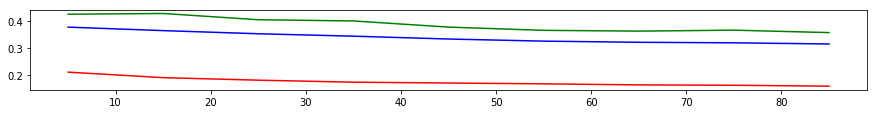

In [26]:

for j in range(1):
    fig = plt.figure(figsize=(15, 5))

    plt.subplot(3,1,j+1)
    
    plt.plot(range(5,86,10), gain_ucb[j] ,'g')
    plt.plot(range(5,86,10), gain_random[j] ,'r')
    plt.plot(range(5,86,10), gain_best_avg[j] ,'b')


In [27]:
d = 15

Valeurs NGDC pour trois méthodes avec le Leave-One-Out :
    * UCB : On recommande les films à travers l'utilisation de l'algo UCB
    * Best-Average : On recommande les films par leur note moyenne
    * Random : On recommande les films par hasard
   

In [46]:
R_d = fill_matrix_MF(R, d)
labels = get_labels_from_clustering(nb_clusters, R_d)
best_movies_by_cluster = get_best_movies_by_cluster(R_d, labels,nb_clusters)       

In [47]:
print('NGDC pour ucb :',gain_NDGC(R_d, delta, best_movies_by_cluster, nb_clusters, nb_rounds = 30, method = "UCB"))
print('NDGC pour best average', gain_NDGC(R_d, delta, best_movies_by_cluster, nb_clusters, nb_rounds = 30, method = "best_average"))
print('NDGC pour random rec', gain_NDGC(R_d, delta, best_movies_by_cluster, nb_clusters, nb_rounds = 20, method = "random"))

NGDC pour ucb : 0.4274865116169021
NDGC pour best average 0.3656356438712425
NDGC pour random rec 0.14892142687750043


# Partie intuitive pour s'assurer du fonctionnement de l'algorithme

In [51]:
nb_rounds = 30
delta = 1/(nb_rounds**2)

R_d = fill_matrix_MF(R, d)
labels = get_labels_from_clustering(nb_clusters, R_d)
best_movies_by_cluster = get_best_movies_by_cluster(R_d, labels,nb_clusters)       


# We take the new user to be a mean between two users of cluster 0 for instance
new_user_group0 = np.mean(R_d[labels==0][0:10],axis = 0)

new_user_group3 = np.mean(R_d[labels==3][0:10],axis = 0)


_,_,_,mu_0= UCB_tot_film(nb_rounds, new_user_group0, delta, best_movies_by_cluster, nb_clusters)
_,_,_,mu_3= UCB_tot_film(nb_rounds, new_user_group3, delta, best_movies_by_cluster, nb_clusters)

print("Les rewards des bras pour l'user du groupe 0 sont :", mu_0)
print("Les rewards des bras pour l'user du groupe 3 sont :", mu_3)

Les rewards des bras pour l'user du groupe 0 sont : [2.62210532 2.21949845 2.07103007 1.41443518 1.24391461 0.49084375]
Les rewards des bras pour l'user du groupe 3 sont : [2.388506   2.49414513 2.31697623 3.7192107  3.70874185 1.13328977]


* On voit que le premier bras(bras 0) pour l'user du groupe 0 et le troisième bras pour l'user du groupe 3. Ils reprèsentent les clusters avec la meilleure note et donc l'algorithme détermine plutot bien l'appartenance de nos utilisateurs)